### Seq2VAR: multivariate time series representation with relational neural networks and linear autoregressive model

##### Edouard Pineau, Sébastien Razakarivony, Thomas Bonald


### ===========================================================================================

#### This notebook presents the results for homogeneous mass-springs system

## Setup

The appendices 'data_generator_permutations.py', 'argument_parser_permutations.py', 'utils.py' and 'modules.py' contain the required supplementary python code for running this notebook. 

In [1]:
import copy
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import time

from utils import *
from modules import *
from argument_parser_springs import *

from itertools import permutations
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
args = argument_parser()
print(args)

Namespace(batch_size=64, cuda=True, in_dim=1, lag=2, nb_samples_per_system=100, nb_systems=10, num_atoms=10, path='/data/tsi/analyse_de_donnees/04-Data/Springs/Datasets/same_graph/', prior=0.5, sd=0, seed=42, stationary=True, suffix='_springs10', timesteps=25)


### Load springs data

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(path=args.path,
                                                                                            batch_size=args.batch_size,
                                                                                            suffix=args.suffix,
                                                                                            shuffle=True, 
                                                                                            data_type='positions', 
                                                                                            binary=not 'continuous' in args.suffix)

args.num_atoms, args.timesteps, args.in_dim = train_loader.dataset[0][0].shape

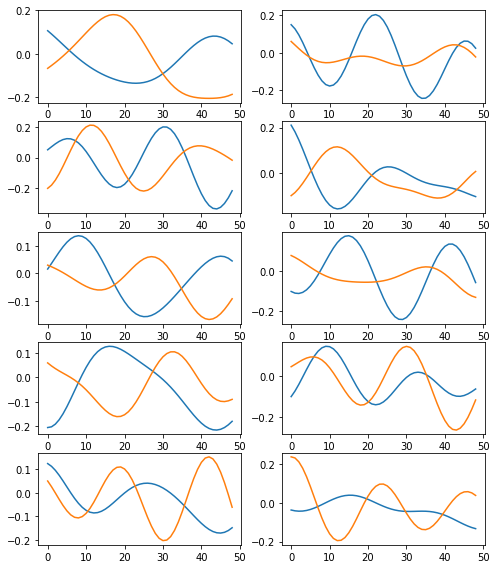

In [4]:
fig = plt.figure(figsize=(8, 20))
for i in range(args.num_atoms):
    fig.add_subplot(args.num_atoms, 2, i + 1)
    plt.plot((train_loader.dataset[0][0][i]).cpu().detach().numpy(), label='prediction')

# Training the different models

### Matrix estimation with standard VAR

VAR has no inference mechanism shared by any number of samples. It is one VAR for one sample. Each new sample requires the fitting of a VAR for representation learning. 

Therefore, no training is required here, we learn at test time.

### Seq2VAR

In [5]:
args_seq2var = argument_parser_seq2var()
args_seq2var.in_dim = args.in_dim
print(args_seq2var)

Namespace(encoder_hidden=64, epochs=2000, in_dim=2, lr=0.0005, tau=0.5)


In [6]:
encoder_seq2var = RelationalEncoder(args.timesteps*args.in_dim, args_seq2var.encoder_hidden, args.lag)

if args.cuda:
    encoder_seq2var = encoder_seq2var.cuda()

optimizer_encoder = optim.Adam(encoder_seq2var.parameters(), lr=args_seq2var.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=250, gamma=0.5)

/home/epineau/anaconda3/envs/edouard/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [ ]:
train_seq2var(train_loader, encoder_seq2var, optimizer_encoder, scheduler, args, args_seq2var)

### Symmetric Seq2VAR

In [8]:
encoder_sym_seq2var = RelationalEncoder(args.timesteps*args.in_dim, args_seq2var.encoder_hidden, args.lag)

if args.cuda:
    encoder_sym_seq2var = encoder_sym_seq2var.cuda()

optimizer_encoder = optim.Adam(encoder_sym_seq2var.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=250, gamma=0.5)

In [ ]:
train_seq2var(train_loader, encoder_sym_seq2var, optimizer_encoder, scheduler, args, args_seq2var, symmetric=True)

### Sparse Seq2VAR

In [10]:
encoder_sparse_seq2var = SparseRelationalEncoder(args.timesteps*args.in_dim, args_seq2var.encoder_hidden, args.lag, common_lag_spike=True)

if args.cuda:
    encoder_sparse_seq2var = encoder_sparse_seq2var.cuda()

optimizer_encoder = optim.Adam(encoder_sparse_seq2var.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=250, gamma=0.5)

In [ ]:
train_seq2var(train_loader, encoder_sparse_seq2var, optimizer_encoder, scheduler, args, args_seq2var, symmetric=False, sparse=True)

### Sparse Symmetric Seq2VAR

In [12]:
encoder_sym_sparse_seq2var = SparseRelationalEncoder(args.timesteps*args.in_dim, args_seq2var.encoder_hidden, args.lag, common_lag_spike=True)

if args.cuda:
    encoder_sym_sparse_seq2var = encoder_sym_sparse_seq2var.cuda()

optimizer_encoder = optim.Adam(encoder_sym_sparse_seq2var.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer_encoder, step_size=250, gamma=0.5)

In [ ]:
train_seq2var(train_loader, encoder_sym_sparse_seq2var, optimizer_encoder, scheduler, args, args_seq2var, symmetric=True, sparse=True)

## NRI

In [14]:
args_nri = argument_parser_nri()
print(args_nri)

Namespace(cuda=True, decoder='mlp', decoder_dropout=0.0, decoder_hidden=64, dynamic_graph=False, edge_types=2, encoder='mlp', encoder_dropout=0.0, encoder_hidden=64, epochs=500, factor=True, gamma=0.5, hard=False, in_dim=4, lr=0.0005, lr_decay=200, no_factor=False, num_atoms=10, prediction_steps=1, prior=False, seed=42, skip_first=False, stationary=True, suffix='_springs10', temp=0.5, var=5e-05)
Namespace(cuda=True, decoder='mlp', decoder_dropout=0.0, decoder_hidden=64, dynamic_graph=False, edge_types=2, encoder='mlp', encoder_dropout=0.0, encoder_hidden=64, epochs=500, factor=True, gamma=0.5, hard=False, in_dim=4, lr=0.0005, lr_decay=200, no_factor=False, num_atoms=10, prediction_steps=1, prior=False, seed=42, skip_first=False, stationary=True, suffix='_springs10', temp=0.5, var=5e-05)


We reload the data since NRI requires additional dimensions for velocity besides location

In [15]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

train_loader_nri, valid_loader_nri, test_loader_nri, _, _, _, _ = load_data(path=args.path,
                                                                            batch_size=args.batch_size,
                                                                            suffix=args.suffix,
                                                                            shuffle=True, 
                                                                            data_type='positions_velocity', 
                                                                            binary=not 'continuous' in args.suffix)

args.num_atoms, args.timesteps, args.in_dim = train_loader_nri.dataset[0][0].shape
args_nri.in_dim = args.in_dim

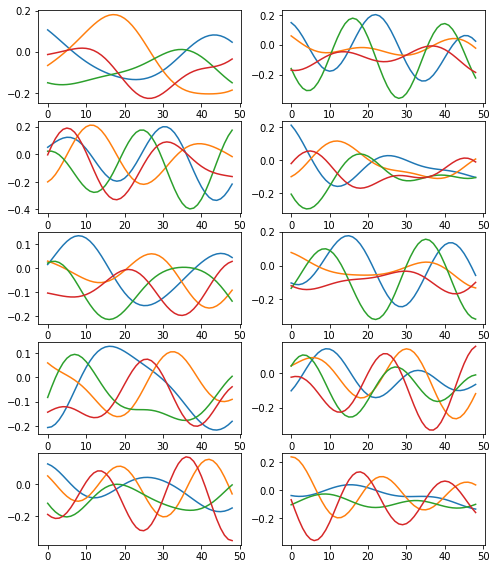

In [16]:
fig = plt.figure(figsize=(8, 20))
for i in range(args.num_atoms):
    fig.add_subplot(args.num_atoms, 2, i + 1)
    plt.plot((train_loader_nri.dataset[0][0][i]).cpu().detach().numpy(), label='prediction')

In [17]:
nri_encoder = RelationalEncoder(args.timesteps*args.in_dim, 
                                 args_nri.encoder_hidden, 
                                 args_nri.edge_types, 
                                 args_nri.encoder_dropout, 
                                 args_nri.factor)
nri_decoder = RelationalDecoder(n_in_node=args.in_dim, 
                                 edge_types=args_nri.edge_types, 
                                 msg_hid=args_nri.decoder_hidden,
                                 msg_out=args_nri.decoder_hidden, 
                                 n_hid=args_nri.decoder_hidden, 
                                 do_prob=args_nri.decoder_dropout,
                                 skip_first=args_nri.skip_first)

if args.cuda:
    nri_encoder.cuda()
    nri_decoder.cuda()
    
optimizer = optim.Adam(list(nri_encoder.parameters()) + list(nri_decoder.parameters()), lr=args_nri.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args_nri.lr_decay, gamma=args_nri.gamma)

Using learned interaction net decoder.


In [ ]:
train_nri(train_loader_nri, nri_encoder, nri_decoder, optimizer, scheduler, args, args_nri)

2best_val_loss = np.inf
best_epoch = 0
for epoch in range(args.epochs):
    train(epoch, train_data_loader, nri_encoder, nri_decoder, rel_rec_nri, rel_send_nri, optimizer, scheduler, args, args_nri)

## Performances

### Classification and causality discovery of the different models

In [64]:
l_test, A_GTs, A_vars, A_nris = [], [], [], []
A_seq2vars, A_sym_seq2vars, A_sparse_seq2vars, A_sym_sparse_seq2vars = [], [], [], []

for data, label, A_gt in test_loader:
    
    l_test.append(label)
    
    # For location only
    X = data
    
    # VAR
    X_var = torch.transpose(X, 1, 2)
    X_var = X_var.contiguous().view(X_var.size(0), X_var.size(1), -1)
    for x in X_var:
        model = VAR(x.numpy())
        results = model.fit(args.lag, trend='c')
        A_vars.append(results.coefs)
    
    # seq2VAR
    
    X = data[:, :, :args.timesteps]
    
    off_diag = np.ones([args.num_atoms, args.num_atoms])
    rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
    rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
    rel_rec = torch.FloatTensor(rel_rec)
    rel_send = torch.FloatTensor(rel_send)
        
    A_seq2var = encoder_seq2var.cpu()(X, rel_rec, rel_send)
    A_seq2vars.append(A_seq2var.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag).cpu().detach())
    
    # symmetric seq2VAR
    A_sym_seq2var = encoder_sym_seq2var.cpu()(X, rel_rec, rel_send)
    A_sym_seq2var = A_sym_seq2var.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag).cpu().detach()
    A_sym_seq2vars.append((A_sym_seq2var + torch.transpose(A_sym_seq2var, 1, 2))/2)
    
    # sparse seq2VAR
    A_sparse_seq2var, _, prespike = encoder_sparse_seq2var.cpu()(X, rel_rec, rel_send)
    spike = (prespike > 0).float()
    A_sparse_seq2var = A_sparse_seq2var.mul(spike)
    A_sparse_seq2var = A_sparse_seq2var.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag)
    A_sparse_seq2vars.append(A_sparse_seq2var.cpu().detach())
    
    # symmetric sparse seq2VAR
    A_sym_sparse_seq2var, _, prespike = encoder_sym_sparse_seq2var.cpu()(X, rel_rec, rel_send)
    spike = (prespike > 0).float()
    A_sym_sparse_seq2var = A_sym_sparse_seq2var.mul(spike)
    A_sym_sparse_seq2var = A_sym_sparse_seq2var.contiguous().view(-1, args.num_atoms, args.num_atoms, args.lag).cpu().detach()
    A_sym_sparse_seq2vars.append((A_sym_sparse_seq2var + torch.transpose(A_sym_sparse_seq2var, 1, 2))/2)

    # NRI
    # We use the loader that contains velocity
    
for data, label, A_gt in test_loader_nri:
    
    X = data[:, :, :args.timesteps]
    
    off_diag = np.ones([args.num_atoms, args.num_atoms]) - np.eye(args.num_atoms)

    rel_rec_nri = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
    rel_send_nri = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
    rel_rec_nri = torch.FloatTensor(rel_rec_nri)
    rel_send_nri = torch.FloatTensor(rel_send_nri)
    
    logits = F.softmax(nri_encoder.cpu()(X, rel_rec_nri, rel_send_nri), 2)
    edges = (logits < 0.5).float()
    
    A_nri = torch.ones(X.size(0), args.num_atoms, args.num_atoms).float()
    for j in range(args.num_atoms):
        A_nri[:, j, [k for k in range(args.num_atoms) if k != j]] = edges[:, j*(args.num_atoms-1):(j+1)*(args.num_atoms-1), 1].cpu()
    A_nris.append(A_nri.cpu().detach())
    
    A_gt_ = torch.ones(X.size(0), args.num_atoms, args.num_atoms).float()
    for j in range(args.num_atoms):
        A_gt_[:, j, [k for k in range(args.num_atoms) if k != j]] = A_gt[:, j*(args.num_atoms-1):(j+1)*(args.num_atoms-1)].cpu().float()
    A_GTs.append(A_gt_.cpu().detach())
    
A_vars = torch.FloatTensor(np.stack(A_vars))
A_seq2vars = torch.cat(A_seq2vars)
A_sparse_seq2vars = torch.cat(A_sparse_seq2vars)
A_sym_seq2vars = torch.cat(A_sym_seq2vars)
A_sym_sparse_seq2vars = torch.cat(A_sym_sparse_seq2vars)
A_nris = torch.transpose(torch.cat(A_nris), 1, 2)
A_GTs = torch.cat(A_GTs)
l_test = torch.cat(l_test)

### Classification performance: accuracy

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [66]:
names = ['VAR\t\t', 'NRI\t\t', 'Seq2VAR\t\t', 'SymSeq2VAR\t', 'SparseSeq2VAR\t', 'SymSparseSeq2VAR\t']
for A_est, name_method in zip([A_vars, A_nris, A_seq2vars, A_sym_seq2vars, A_sparse_seq2vars, A_sym_sparse_seq2vars], names):
    X_train, X_test, y_train, y_test = train_test_split(A_est.reshape(A_est.shape[0], -1).numpy(), l_test.numpy())
    rf = KNeighborsClassifier(n_neighbors=1)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    
    print(name_method, 'Accuracy:', np.mean(rf.predict(X_test.reshape(X_test.shape[0], -1))==y_test))

VAR		 Accuracy: 0.5652
NRI		 Accuracy: 1.0
Seq2VAR		 Accuracy: 0.9992
SymSeq2VAR	 Accuracy: 0.9996
SparseSeq2VAR	 Accuracy: 0.9996
SymSparseSeq2VAR	 Accuracy: 1.0


### Causality detection performance: F1-score

Building adjency matrix of the unweighted DAG
- For VAR

In [67]:
size = [1, args.lag, args_seq2var.in_dim, args_seq2var.in_dim]
weight = (torch.ones(args_seq2var.in_dim, args_seq2var.in_dim).unsqueeze(0).unsqueeze(0)).expand(size) / args_seq2var.in_dim

A_vars_mean = F.conv2d(A_vars, weight, stride=args_seq2var.in_dim)
W = F.conv2d(A_vars.abs(), weight, stride=args_seq2var.in_dim)
A_vars_binarized = torch.FloatTensor(np.concatenate([(np.abs(w) > np.percentile(np.abs(w), q=args.prior*100)) for w in W]).astype(float))

- For dense Seq2VAR

In [68]:
A_seq2vars_binarized = torch.stack([(w.sum(-1).abs() > np.percentile(w.sum(-1).abs(), q=args.prior*100)) for w in A_seq2vars]).float()
A_sym_seq2vars_binarized = torch.stack([(w.sum(-1).abs() > np.percentile(w.sum(-1).abs(), q=args.prior*100)) for w in A_sym_seq2vars]).float()

- For sparse Seq2VAR

In [69]:
A_sparse_seq2vars_binarized = (A_sparse_seq2vars.abs().sum(-1) != 0).float()
A_sym_sparse_seq2vars_binarized = (A_sym_sparse_seq2vars.abs().sum(-1) != 0).float()

Causality discovery with F1-score

In [70]:
names = ['VAR\t\t', 'NRI\t\t', 'Seq2VAR\t\t', 'SymSeq2VAR\t', 'SparseSeq2VAR\t', 'SymSparseSeq2VAR\t']
for A_est, name_method in zip([A_vars_binarized, A_nris, A_seq2vars_binarized, A_sym_seq2vars_binarized, A_sparse_seq2vars_binarized, A_sym_sparse_seq2vars_binarized], names):
    A_est = A_est.float()
    tp = (A_GTs*A_est).sum()
    fp = ((1-A_GTs)*A_est).sum()
    fn = (A_GTs*(1-A_est)).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    F_score = 2*precision*recall/(precision+recall)
    print(name_method, 'precision:', "%.2f" % precision.item(), '\trecall:', "%.2f" % recall.item(), '\tF1_score:', "%.2f" % F_score.item())

VAR		 precision: 0.61 	recall: 0.57 	F1_score: 0.59
NRI		 precision: 0.94 	recall: 0.96 	F1_score: 0.95
Seq2VAR		 precision: 0.93 	recall: 0.88 	F1_score: 0.91
SymSeq2VAR	 precision: 0.95 	recall: 0.89 	F1_score: 0.92
SparseSeq2VAR	 precision: 0.93 	recall: 0.88 	F1_score: 0.91
SymSparseSeq2VAR	 precision: 0.95 	recall: 0.89 	F1_score: 0.92


## Further analysis

In [71]:
distances = np.array([[torch.norm(A_gt - A_est[i], 1) for i,A_gt in enumerate(A_GTs)] for A_est in [A_vars_binarized, A_nris, A_seq2vars_binarized, A_sym_seq2vars_binarized, A_sparse_seq2vars_binarized, A_sym_sparse_seq2vars_binarized]])

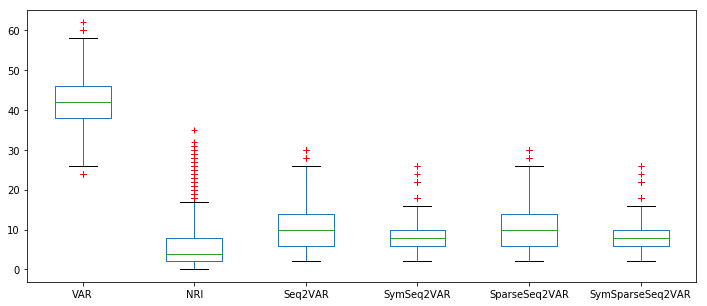

In [72]:
pd.DataFrame(distances.T, columns=['VAR', 'NRI', 'Seq2VAR', 'SymSeq2VAR', 'SparseSeq2VAR', 'SymSparseSeq2VAR']).plot.box(sym='r+', figsize=(12,5))

A_vars_binarized, A_nris, A_seq2vars_binarized, A_sym_seq2vars_binarized, A_sparse_seq2vars_binarized, A_sym_sparse_seq2vars_binarized

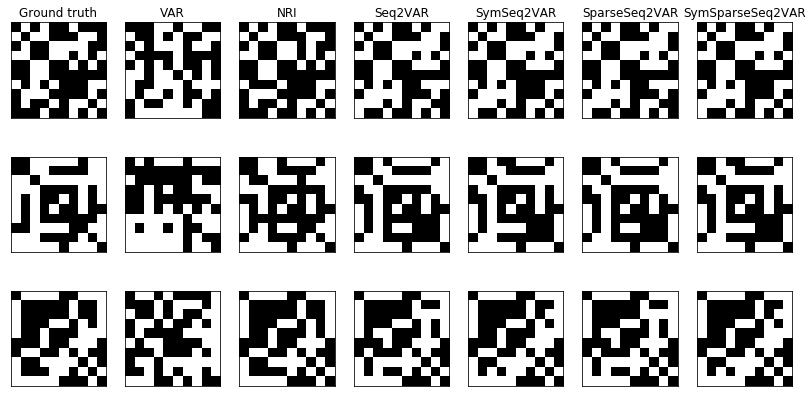

In [73]:
fig, axes = plt.subplots(3, 7, figsize=(14, 7))
for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
    
    
for i in range(3):
    j = np.random.randint(len(test_loader.dataset))
    
    # all plots
    
    axes[i, 0].imshow(A_GTs[j], cmap='binary', label='ground truth')
    axes[i, 1].imshow(A_vars_binarized[j], cmap='binary')
    axes[i, 2].imshow(A_nris[j], cmap='binary')
    axes[i, 3].imshow(A_seq2vars_binarized[j].numpy(), cmap='binary')
    axes[i, 4].imshow(A_sym_seq2vars_binarized[j].numpy(), cmap='binary')
    axes[i, 5].imshow(A_sparse_seq2vars_binarized[j].numpy(), cmap='binary')
    axes[i, 6].imshow(A_sym_sparse_seq2vars_binarized[j].numpy(), cmap='binary')
    
    
for ax, name in zip(axes[0], ['Ground truth', 'VAR', 'NRI', 'Seq2VAR', 'SymSeq2VAR', 'SparseSeq2VAR', 'SymSparseSeq2VAR']):
    ax.set_title(name)
plt.show(block=False)